## Creating Biased Datasets Using Simstudy

In this notebook, we will be using Simstudy to simulate a dataset in which certain outcomes are biased, conditional on certain characteristics. We aim to demonstrate how Simstudy can be used to develop accelerators, as well as Trustworthy AI demos. By specifying the relationships between inputs and outputs ahead of time, we can see how well different algorithms do at estimating these relationships.

Let's start with the building blocks of the pysimstudy package. 

The goal of this first example is to display the core steps in generating data with pysimstudy, while also exploring the art of whats possible through interesting questions of statistical nature. We will work to create a dataset of people represented by an arbitrary id, along with their income. The target variable will be approval, which will be biased to have more approvals if your income is higher. Our goal is to show that we can hard-code bias into an approval rating process based on a random variable.

The first step is to define a _definitions_ data table in which we describe the variables we want to generate. We pass arguments to define the generated variable's name (varname), as well as its statistical parameters. The _formula_ argument refers to the variable's mean, or expected value, and _variance_ is self evident. The _formula_ argument allows you to pass an equation to generate your data.

In [1]:
from pysimstudy import *

In [2]:
ddf = defData(varname = "region", formula="0.333, 0.333, 0.333",
             variance="red, blue, green", dist="categorical")


We then define our target variable, __approval__. We add a new row to the data definitions table created in the previous lines of code by passing _df_ as the first argument. The _formula_ is defined as follows: the probability of an individual being approved is 50% +/- their relative income. In other words, inviduals who are on the higher (lower) end of the income scale will be more (less) likely to receive an approval.


In [3]:
ddf = defData(ddf, varname="approval", formula='.5', dist='binary')

In [4]:
gdf = genData(10000, ddf)
gdf.head()

,id,region,approval
0,0,green,0
1,1,blue,1
2,2,blue,1
3,3,red,0
4,4,green,0


In the example below, we want our __income__ variable to be centered at 5000, but as we will see later on, we can also make the formula dependent on previously written data definitions to generate complex dependencies in the synthetic data. Note that the _variance_ argument is squared in this case, since the standard deviation is the square-root of variance.

In [5]:
ddf = defData(varname = "income", formula=5000,
             variance="1000**2", dist="normal")
# print the data definition dataframe
ddf

,varname,formula,variance,dist,link
0,income,5000,1000**2,normal,identity


In [6]:
gdf = genData(10000, ddf)
gdf.head()

,id,income
0,0,4947.901323
1,1,4300.734517
2,2,4891.009997
3,3,3430.169521
4,4,5476.881927


In [7]:
# Now we can create conditions to influence our data
defC = defCondition(condition = "income >= 6000", formula = "0.9",
                    dist = "binary")

defC = defCondition(defC, condition = "(income < 6000) & (income >= 4000)", formula = "0.65",
                    dist = "binary")

defC = defCondition(defC, condition = " (income < 4000)", formula = "0.4",
                    dist = "binary")


In [8]:
defC

,condition,formula,variance,dist,link
0,income >= 6000,0.9,0,binary,identity
0,(income < 6000) & (income >= 4000),0.65,0,binary,identity
0,(income < 4000),0.4,0,binary,identity


Now that we created the conditions for our dataset, we can generate observations based on the previously defined conditions.

In [9]:
gdfb = addCondition(defC, gdf, newvar="approval")

In [10]:
gdfb.head()

,id,income,approval
0,9,6538.616431,1
1,11,6491.355164,1
2,24,7457.766388,1
3,25,6192.585798,1
4,32,6223.788481,0


Notice how each of the conditions we defined combine into one condition table

pysimstudy then took our conditions and resulted in a newly generated column with a binary distribution of observations with positive observations equal to the decimal passed into formula argument.

In [11]:
gdfb[gdfb['income'] >= 6000]['approval'].value_counts(normalize=True)

1    0.897172
0    0.102828
Name: approval, dtype: float64

This is the same for the other brackets

In [12]:
gdfb[(gdfb['income'] < 6000) & (gdfb['income'] >=4000)]['approval'].value_counts(normalize=True)

1    0.650766
0    0.349234
Name: approval, dtype: float64

In [13]:
gdfb[gdfb['income'] < 4000]['approval'].value_counts(normalize=True)

0    0.595972
1    0.404028
Name: approval, dtype: float64

In [14]:
gdfb['approval'].value_counts(normalize=True)

1    0.6499
0    0.3501
Name: approval, dtype: float64

Sometimes it's not that clear to observe how biased data presents itself without using a nice bar graph

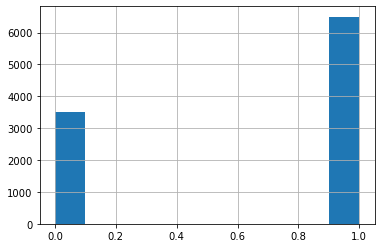

In [15]:
gdfb['approval'].hist();

In [16]:
gdf.head()

,id,income
0,0,4947.901323
1,1,4300.734517
2,2,4891.009997
3,3,3430.169521
4,4,5476.881927
